In [14]:
import sys
import os
sys.path.append('/Users/syesw/Desktop/JL-Code_Project/athena')

In [15]:
from dotenv import load_dotenv
load_dotenv()

rqdata_username = os.getenv('RQDATA_USERNAME')
rqdata_password = os.getenv('RQDATA_PASSWORD')

In [16]:
import rqdatac as rq

In [17]:
from athena import RiceQuantDataHandler, Strategy, Backtest
from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [18]:
# 设置时间范围
start_date = '2020-01-01'
end_date = '2021-01-01'
#asset_list = ['000651.XSHE', '600000.XSHG']
#asset_list = rq.index_components('000300.XSHG')
rqdata = RiceQuantDataHandler(start_date, end_date)
rqdata.auth(rqdata_username,rqdata_password)

asset_list = rqdata.get_index_list('000300.XSHG')

/Users/syesw/anaconda3/envs/py310/lib/python3.10/site-packages/rqdatac/client.py:211: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [19]:
len(asset_list)

300

In [20]:
factor_data = rqdata.get_factors_from_ricequant(list=asset_list, factors=['market_cap'])

开始获取数据
数据获取完成
开始转换数据结构


In [21]:
backtest_data = rqdata.get_prices_from_ricequant(list=asset_list, fields=['open', 'high', 'low', 'close', 'volume'])

开始获取数据
数据获取完成
开始转换数据结构


In [22]:
class SingleAssetStrategy(Strategy):
    def init(self):
        print("回测准备:")
        self.first_time = True

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factor_data.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'market_cap') # 从高到低排因子

        print('因子排名前5的股票:')
        print(sorted_factor_series[:5].index.tolist())
        short_stocks = sorted_factor_series[:5].index.tolist()
        print('因子排名后5的股票:')
        print(sorted_factor_series[-5:].index.tolist())
        long_stocks = sorted_factor_series[-5:].index.tolist()

        # 先换仓
        long_closed = short_closed = 0
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                long_closed += 1
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                short_closed += 1

        total_closed = long_closed + short_closed
        if self.first_time == True:
            re_invest_size = 1 / 10 # 10只股票
        else: re_invest_size = 1 / total_closed

        # 买进新的股票
        # 这里的换仓逻辑是，不去干涉已经开仓的股票(不加仓)
        # 对于新开仓的股票，按可分配资金的数量(1/total_closed)来开仓
        # 这样做实现了滚仓的效果
        for stock in long_stocks:
            if long_closed == 0 and self.first_time == False:
                break
            if stock not in current_long_positions:
                print("新开多仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=False)
                long_closed -= 1
        for stock in short_stocks:
            if short_closed == 0 and self.first_time == False:
                break
            if stock not in current_short_positions:
                print("新开空仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=True)
                short_closed -= 1
        
        self.first_time == False

        print("----------------------")


In [23]:
backtest = Backtest(SingleAssetStrategy, backtest_data, commission=.001, cash=1000000)

In [24]:
res = backtest.run()

回测准备:
----------------------
2020-01-02 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前5的股票:
['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名后5的股票:
['601216.XSHG', '600998.XSHG', '600522.XSHG', '600118.XSHG', '002414.XSHE']
新开多仓: 601216.XSHG
新开多仓: 600998.XSHG
新开多仓: 600522.XSHG
新开多仓: 600118.XSHG
新开多仓: 002414.XSHE
新开空仓: 601398.XSHG
新开空仓: 601939.XSHG
新开空仓: 601318.XSHG
新开空仓: 600519.XSHG
新开空仓: 601288.XSHG
----------------------
----------------------
2020-02-03 00:00:00: 
我目前持仓情况:
多头仓位: ['601216.XSHG', '600998.XSHG', '600522.XSHG', '600118.XSHG', '002414.XSHE']
空头仓位: ['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名前5的股票:
['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名后5的股票:
['600369.XSHG', '601555.XSHG', '600109.XSHG', '600522.XSHG', '601216.XSHG']
关多仓: 600998.XSHG
关多仓: 600118.XSHG
关多仓: 002414.XSHE
新开多仓: 600369.XSHG
新开多仓: 601555.XSHG
新开多仓: 600109.XSHG
----------------------
----------------------
20

In [25]:
len(res.trades)

28

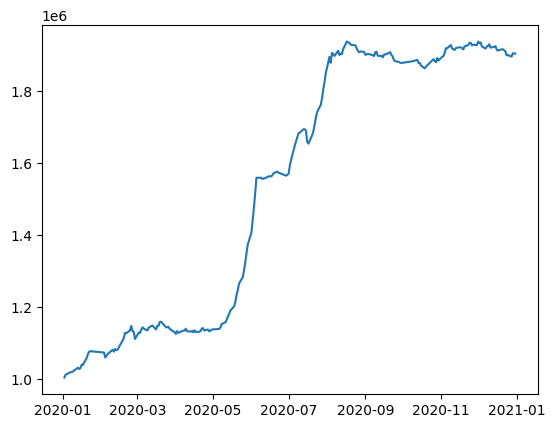

In [26]:
import matplotlib.pyplot as plt
plt.plot(res.returns)